<img src="../img/banner.png" width="500" align="center">

# Procesamiento de lenguaje natural
## LSTM Bot QA

Preparado por: Alan Churichi

Se utilizará un dataset de conversaciones en ingles con el objetivo de entrenar un bot con el que podamos interactuar mediante preguntas y respuestas.

El bot conversacional se entrenará haciendo uso de una arquitectura LSTM encoder-decoder.

Finalmente se evaluará el rendimiento del bot haciendole preguntas y teniendo una breve conversación para ver la coherencia de sus respuestas.

[Link al dataset](http://convai.io/data/)

In [1]:
%load_ext lab_black

sys.path.insert(1, "/tf/notebooks/CEIA/nlp/clase-6")

from embeddings import GloveEmbeddings
from keras.layers import Input, LSTM, Dense
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
import gdown
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import sys

base_path = "/tf/notebooks/CEIA/nlp/clase-6"

### 1 - Datos

Se descarga la carpeta del dataset

In [2]:
dataset_path = os.path.join(base_path, "data/data_volunteers.json")

if os.access(dataset_path, os.F_OK) is False:
    url = "https://drive.google.com/uc?id=1QPYxMTBSGNmbyGhknznuO3YWLBOJnhUQ&export=download"
    gdown.download(url, dataset_path, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


Se carga el dataset y mostramos un ejemplo

In [3]:
with open(dataset_path) as f:
    data = json.load(f)

data[0]

{'dialog': [{'id': 0,
   'sender': 'participant1',
   'text': 'hi there',
   'evaluation_score': None,
   'sender_class': 'Human'}],
 'start_time': '2018-10-29 03:32:08.296000',
 'end_time': '2018-10-29 03:32:08.296000',
 'bot_profile': ['i like to talk but people have a hard time understanding.',
  'i like to look at blocks and sing about letters.',
  'i like to eat chocolate candy.',
  'when i grow up i want to be a dog.'],
 'user_profile': ['i am a clean eater.',
  'my parents were both very athletic.',
  'i love running and preparing for marathons.',
  'i am a cancer survivor.'],
 'eval_score': None,
 'profile_match': '',
 'participant1_id': {'class': 'User', 'user_id': 'User 00172'},
 'participant2_id': {'class': 'Bot', 'user_id': 'Bot 004'}}

Se procesa el dataset para obtener los datos en el formato necesario para entrenar nuestro modelo.

In [4]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30


def clean_text(txt):
    txt = txt.lower()
    txt.replace("'d", " had")
    txt.replace("'s", " is")
    txt.replace("'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r"\W+", " ", txt)

    return txt


for line in data:
    for i in range(len(line["dialog"]) - 1):
        chat_in = clean_text(line["dialog"][i]["text"])
        chat_out = clean_text(line["dialog"][i + 1]["text"])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + " <eos>"
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = "<sos> " + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

Cantidad de rows utilizadas: 6033


('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento

Se realiza el preprocesamiento necesario para obtener:

- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [5]:
# Tamaño máximo del vocabulario
MAX_VOCAB_SIZE = 8000

Se utiliza `Tokenizer` de Keras para generar los tokens de las palabras en el dataset.

In [6]:
tokenizer = Tokenizer(
    num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
)  # Se omiten los simbolos "<" y ">" para que no afectar los delimintadores "<sos>" y "<eos>"
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences)
input_integer_seq = tokenizer.texts_to_sequences(input_sentences)
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx = tokenizer.word_index
max_input_len = max(len(sen) for sen in input_integer_seq)
max_out_len = max(len(sen) for sen in output_integer_seq)
num_words_output = min(
    len(word2idx) + 1, MAX_VOCAB_SIZE
)  # Se suma 1 por el primer <sos>

print("Palabras en el vocabulario:", len(word2idx))
print("Sentencia de entrada más larga:", max_input_len)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 2157
Sentencia de entrada más larga: 9
Sentencia de salida más larga: 10


In [7]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
decoder_input_sequences = pad_sequences(
    output_input_integer_seq, maxlen=max_out_len, padding="post"
)

print("Cantidad de rows del dataset:", len(input_integer_seq))
print("encoder_input_sequences shape:", encoder_input_sequences.shape)
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 9)
decoder_input_sequences shape: (6033, 10)


In [8]:
decoder_output_sequences = pad_sequences(
    output_integer_seq, maxlen=max_out_len, padding="post"
)
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 10, 2158)

### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores.

En este caso utilizaremos Glove.

In [9]:
embeddings_path = os.path.join(base_path, "data/gloveembedding.pkl")

if os.access(embeddings_path, os.F_OK) is False:
    url = "https://drive.google.com/uc?id=1wlDBOrxPq2-3htQ6ryVo7K1XnzLcfh4r&export=download"
    gdown.download(url, embeddings_path, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


Utilizamos las funciones auxiliares definidas en `embeddings.py` para cargar los embeddings.

In [10]:
word_to_vec_model_txt_path = os.path.join(base_path, "data/glove.twitter.27B.50d.txt")

model_embeddings = GloveEmbeddings(
    word_to_vec_model_txt_path=word_to_vec_model_txt_path,
    pkl_path=embeddings_path,
)

Se crea la matriz de embedding para las secuencias en ingles.

In [11]:
print("preparing embedding matrix...")
embed_dim = model_embeddings.n_features
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx))  # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:

        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print("number of null word embeddings:", np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 44


Dimensión de los embeddings de la secuencia en ingles

In [12]:
embedding_matrix.shape

(2157, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [13]:
n_units = 256

encoder_inputs = Input(shape=(max_input_len))

encoder_embedding_layer = Embedding(
    input_dim=nb_words,  # definido en el Tokenizador
    output_dim=embed_dim,  # dimensión de los embeddings utilizados
    input_length=max_input_len,  # máxima sentencia de entrada
    weights=[embedding_matrix],  # matrix de embeddings
    trainable=False,
)

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len))
decoder_embedding_layer = Embedding(
    input_dim=num_words_output, output_dim=n_units, input_length=max_out_len
)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])
model.summary()

2022-08-18 00:53:44.119511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:53:44.124073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:53:44.124234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 00:53:44.124808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 9)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 9, 50)        107850      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 256)      552448      ['input_2[0][0]']                
                                                                                              

Modelo completo encoder-decoder

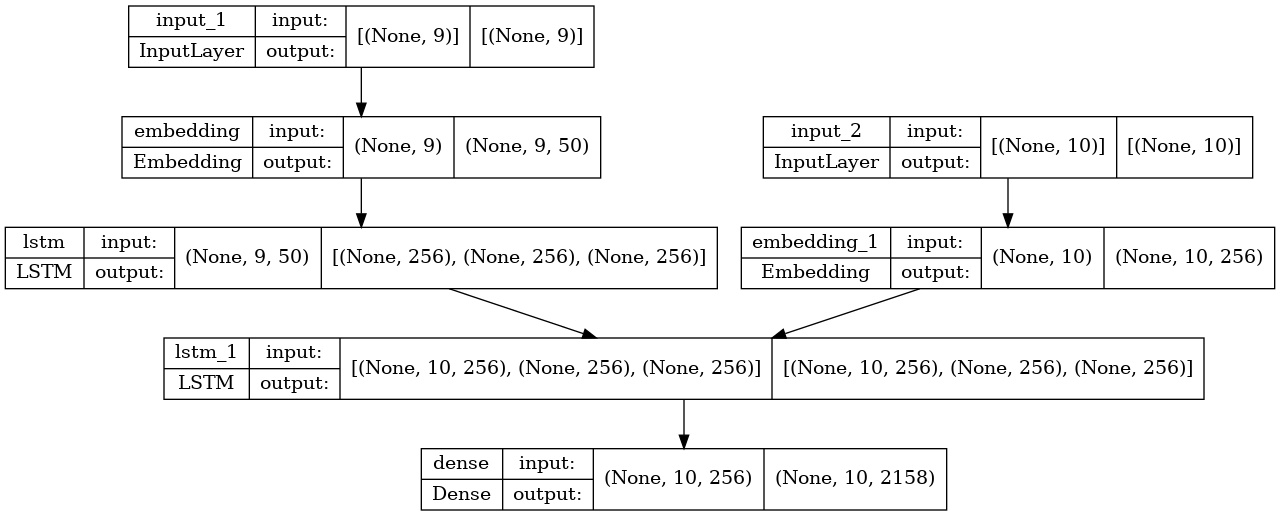

In [14]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Modelo encoder

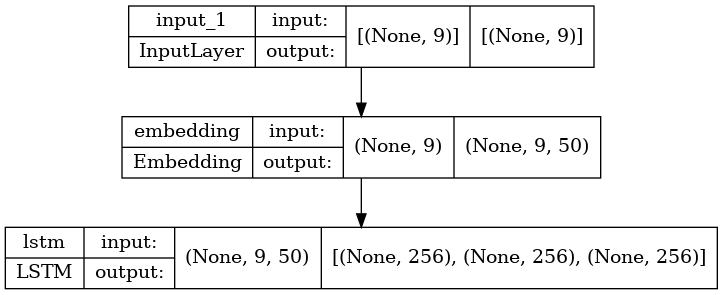

In [15]:
encoder_model = Model(encoder_inputs, encoder_states)


plot_model(
    encoder_model, to_file="encoder_plot.png", show_shapes=True, show_layer_names=True
)

Modelo decoder para realizar inferencias

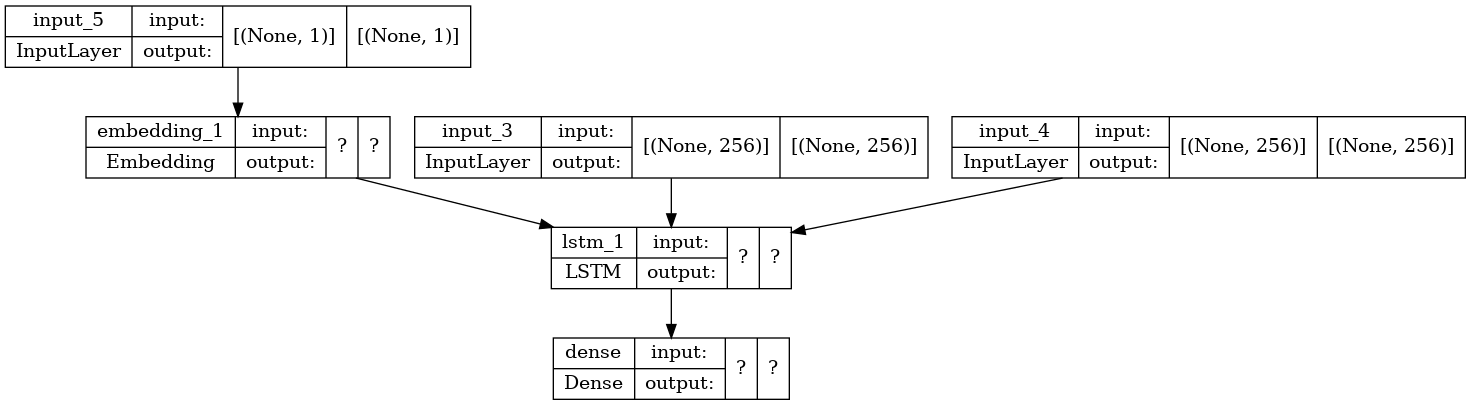

In [16]:
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs_single_x, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

plot_model(
    decoder_model, to_file="decoder_plot.png", show_shapes=True, show_layer_names=True
)

Se entrena el modelo encoder-decoder

In [17]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2,
)

Epoch 1/50


2022-08-18 00:53:49.179111: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


151/151 [==============================] - 5s 11ms/step - loss: 2.6749 - accuracy: 0.5680 - val_loss: 2.1254 - val_accuracy: 0.6458
Epoch 2/50
151/151 [==============================] - 1s 6ms/step - loss: 1.7929 - accuracy: 0.6868 - val_loss: 1.8534 - val_accuracy: 0.6959
Epoch 3/50
151/151 [==============================] - 1s 7ms/step - loss: 1.5344 - accuracy: 0.7263 - val_loss: 1.7552 - val_accuracy: 0.7127
Epoch 4/50
151/151 [==============================] - 1s 6ms/step - loss: 1.4058 - accuracy: 0.7412 - val_loss: 1.6961 - val_accuracy: 0.7191
Epoch 5/50
151/151 [==============================] - 1s 6ms/step - loss: 1.3224 - accuracy: 0.7479 - val_loss: 1.6705 - val_accuracy: 0.7215
Epoch 6/50
151/151 [==============================] - 1s 7ms/step - loss: 1.2572 - accuracy: 0.7540 - val_loss: 1.6398 - val_accuracy: 0.7272
Epoch 7/50
151/151 [==============================] - 1s 6ms/step - loss: 1.2043 - accuracy: 0.7608 - val_loss: 1.6294 - val_accuracy: 0.7290
Epoch 8/50
151/1

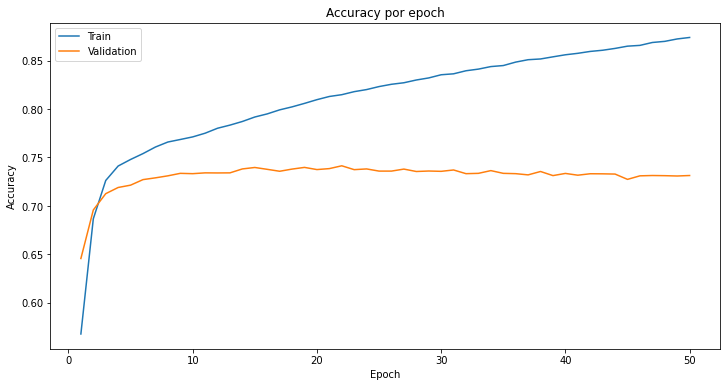

In [18]:
epoch_count = range(1, len(hist.history["accuracy"]) + 1)
plt.figure(figsize=(12, 6))
sns.lineplot(x=epoch_count, y=hist.history["accuracy"], label="Train")
sns.lineplot(x=epoch_count, y=hist.history["val_accuracy"], label="Validation")
plt.title("Accuracy por epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

Definimos una funcion que dado un texto de entrada haga el preprocesamiento necesario y alimente el modelo para obtener una respuesta.

In [19]:
# Conversor de indice a palabra:
idx2word = {v: k for k, v in word2idx.items()}


def get_response(input_text):
    integer_seq = tokenizer.texts_to_sequences([input_text])[0]
    input_seq = pad_sequences([integer_seq], maxlen=max_input_len)

    # Se transforma la sequencia de entrada a los stados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder"
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx["<sos>"]

    # Se obtiene el indice que finaliza la inferencia
    eos = word2idx["<eos>"]

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ""
        if idx > 0:
            word = idx2word[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la ultima prediccion
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (realimentacion)
        target_seq[0, 0] = idx

    return " ".join(output_sentence)

In [20]:
def chat(input_text):
    response = get_response(input_text)

    print("Input:", input_text)
    print("Response:", response)

In [21]:
questions = [
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",
    "How are you?",
    "What do you like?",
    "How do you look like?",
    "Do you cook?",
]

for question in questions:
    chat(question)
    print("\n")

Input: Do you read?
Response: i am not sure what you mean


Input: Do you have any pet?
Response: no


Input: Where are you from?
Response: i am from the united states


Input: How are you?
Response: i am doing well how are you


Input: What do you like?
Response: i like to play video games


Input: How do you look like?
Response: i am not sure what you mean


Input: Do you cook?
Response: yes




In [23]:
import time

user_input = None

while user_input != "":
    user_input = input()
    if user_input != "":
        chat(user_input)
        time.sleep(1)

Input: Hello
Response: hello how are you
Input: I am fine and you?
Response: i am doing well how are you
Input: very well. Do you read?
Response: i like to play video games
Input: Me too! What kind of video games?
Response: i do not like it
Input: Ok. What do you like?
Response: i like to play video games
Input: And do you have pets?
Response: i do not have any
Input: I have to leave now
Response: what do you like
Input: Bye bye
Response: i am not sure what you mean


Podemos concluir en que el bot funciona de manera aceptable para los pocos datos de entrenamiento y la arquitectura simple que se utilizó. 

Si bien no en todos los casos la respuestas se condicen con las preguntas, al menos es bastante coherente en la forma de escribir y se logra entender lo que está tratando de decir.

Probablemente un dataset con mayor cantidad de datos de mejores resultados.